In [26]:
from PIL import Image
from skimage import measure
import numpy as np 
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans

Image_folder = 'Y:\coskun-lab\Thomas\Mayar-Data\Image'
Mask_folder = 'Y:\coskun-lab\Thomas\Mayar-Data\Mask'
Cluster_folder = 'Y:\coskun-lab\Thomas\Mayar-Data\Clusters'

%matplotlib inline

In [27]:
# Experiment
experiment = 'DT14'

X = None
X2= None
markers = []
imgs = []
masks = []

for (dirpath, dirnames, filenames) in os.walk(Mask_folder):
    for name in sorted(filenames):
        if 'BM' in name and experiment in name:
            img = cv2.imread(os.path.join(dirpath,name),0)
            masks.append(img)
            img = img.flatten()
            X = np.concatenate((X, img[None]), axis=0) if X is not None else img[None]
            
for (dirpath, dirnames, filenames) in os.walk(Image_folder):
    for name in sorted(filenames):
        if 'tiff' in name and experiment in name:
            img = cv2.imread(os.path.join(dirpath,name),0)
            imgs.append(img)
            markers.append(name.split('_')[1].split('.')[0])
            
for i in range(len(imgs)):
    img = cv2.bitwise_and(imgs[i], imgs[i], mask = masks[i])
    img = img.flatten()
    X2 = np.concatenate((X2, img[None]), axis=0) if X2 is not None else img[None]

In [28]:
# for i in range(len(imgs)):
#     img = cv2.bitwise_and(imgs[i], imgs[i], mask = masks[i])
#     plt.imshow(img)
#     plt.title(markers[i])
#     plt.show()

In [29]:
from sklearn.cluster import KMeans

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters,random_state = 2, n_init=15).fit(X/255.0)
labels = kmeans.labels_

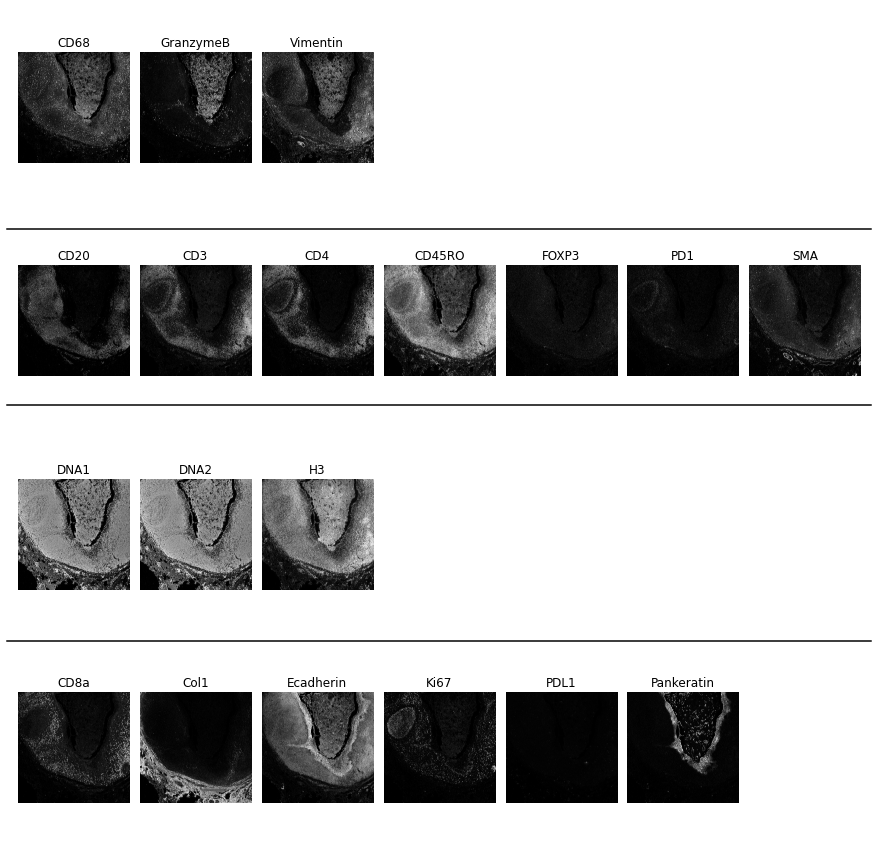

In [30]:
import collections

count = collections.Counter(labels)
columns = max(count.values())

fig, axs = plt.subplots(n_clusters, columns, figsize=(12, 12))
for i in range(n_clusters):
    j = 0
    for k, label in enumerate(labels):
        if label == i:
            axs[i][j].imshow(imgs[k], cmap = 'gray')
            axs[i][j].set_title(markers[k])
            axs[i][j].set_ylabel('common ylabel')
            j += 1
            
            
for i in range(n_clusters):
    for j in range(columns):
        axs[i][j].axis('off')

# rearange the axes for no overlap
fig.tight_layout()

# Get the bounding boxes of the axes including text decorations
r = fig.canvas.get_renderer()
get_bbox = lambda ax: ax.get_tightbbox(r).transformed(fig.transFigure.inverted())
bboxes = np.array(list(map(get_bbox, axs.flat)), mtrans.Bbox).reshape(axs.shape)

#Get the minimum and maximum extent, get the coordinate half-way between those
ymax = np.array(list(map(lambda b: b.y1, bboxes.flat))).reshape(axs.shape).max(axis=1)
ymin = np.array(list(map(lambda b: b.y0, bboxes.flat))).reshape(axs.shape).min(axis=1)
ys = np.c_[ymax[1:], ymin[:-1]].mean(axis=1)

# Draw a horizontal lines at those coordinates
for y in ys:
    line = plt.Line2D([0,1],[y,y], transform=fig.transFigure, color="black")
    fig.add_artist(line)
    
plt.show()

In [31]:
fig.savefig(str(n_clusters) + 'clustering.png', bbox_inches='tight')

In [32]:
# for i in range(n_clusters):
#     j = 0
#     avg_imgs = []
#     for k, label in enumerate(labels):
#         if label == i:
#             avg_imgs.append(imgs[k])
#     arr = np.array(np.mean(avg_imgs, axis=(0)), dtype=np.uint8)
#     out = Image.fromarray(arr)        
#     out.save(experiment + '_cluster'+ str(i) + '.png')

In [33]:
# data = {'Marker':markers, 'Cluster':labels}
# df = pd.DataFrame(data)
# df.to_csv(experiment + '_info.csv', index=False)